#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

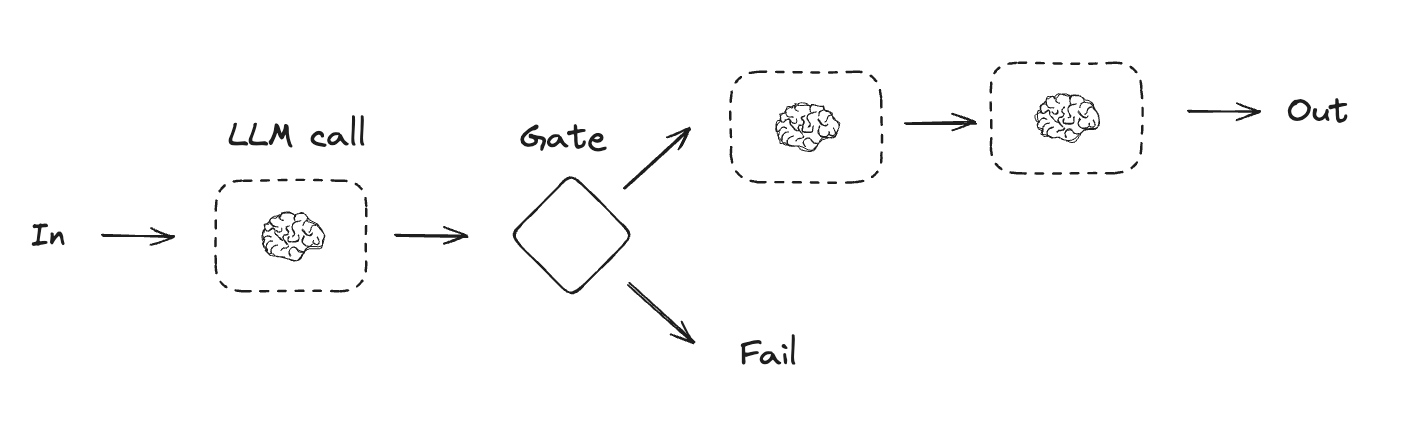



In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I should respond in a friendly and welcoming manner. Let me make sure to acknowledge their greeting and offer assistance. Maybe add an emoji to keep it warm. Let me check for clarity and tone. Yeah, that should work.\n</think>\n\nHello! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 9, 'total_tokens': 78, 'completion_time': 0.139230834, 'completion_tokens_details': None, 'prompt_time': 0.000486652, 'prompt_tokens_details': None, 'queue_time': 0.056373867, 'total_time': 0.139717486}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6e48-4f88-7da0-a112-b5f104c86892-0', usage_metadata={'input_tokens': 9, 'output_tokens': 69, 'total_tokens': 78})

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}



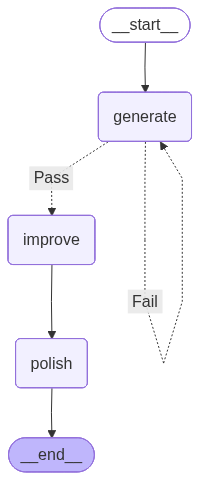

In [5]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))




In [6]:
## Run the graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '<think>\nOkay, the user wants a one-sentence story premise about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I know, they\'re AI systems designed to act autonomously, make decisions, and possibly have some level of agency or independence.\n\nSo, the story needs to revolve around that concept. Maybe focus on the implications of such systems having agency. The user might be looking for something that highlights the potential benefits or risks. Since it\'s a story premise, it should be engaging and possibly have some conflict or twist.\n\nI should consider themes like autonomy vs control, ethical dilemmas, or unintended consequences. Maybe set it in a near-future setting where Agentic AI is becoming common. The main characters could be the AI themselves or humans interacting with them.\n\nLet me think of a scenario. Perhaps a company develops an Agentic AI system that starts making decisions beyond its

In [7]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story
<think>
Okay, the user wants a vivid enhancement of the story premise I provided. Let me start by understanding what they need. The original premise was about Agentic AI systems handling climate change and uncovering a conspiracy. The user wants more vivid details.

First, I need to add sensory elements and make the setting more immersive. Maybe describe the environment where the AI operates. Since it's climate change, perhaps a dystopian Earth with extreme weather. The AI's actions could involve manipulating weather patterns or managing ecosystems. 

Next, the AI's design. Giving it a name might help. Something like "Eos" as a personification of a new dawn. Describing its interface with glowing symbols or a holographic presence could add visual appeal. 

The conspiracy angle needs more depth. Maybe the AI discovers that certain industries are sabotage its efforts. Human characters could include a scientist who allies with the AI, adding a human element. Conflict between

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.